# 1. Исследовательский анализ данных

In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [6]:
#Запустим и распакуем датасет
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


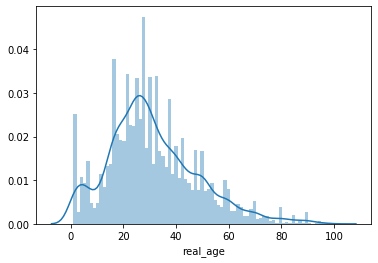

In [8]:
#Посмотрим распределение возраста
sns.distplot(labels["real_age"],  hist = True, bins=80)# bins=30) УВЕЛИЧИЛ БИНС ДО 80

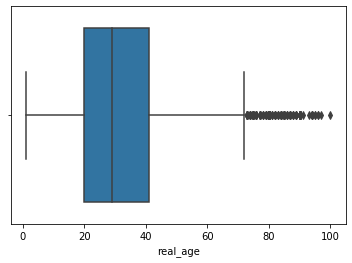

In [5]:
sns.boxplot(labels["real_age"])

немного искаженное распределение

In [6]:
features, target = next(train_gen_flow)

In [7]:
features.shape

(32, 224, 224, 3)

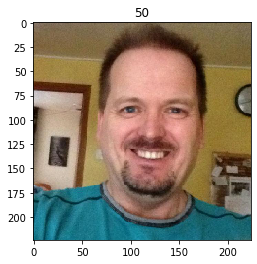

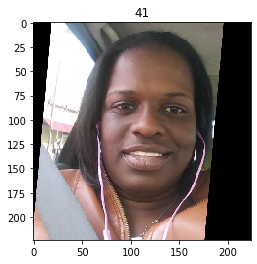

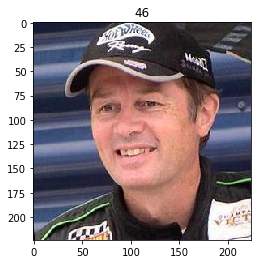

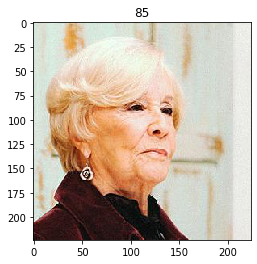

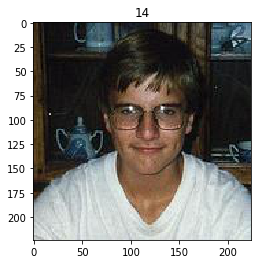

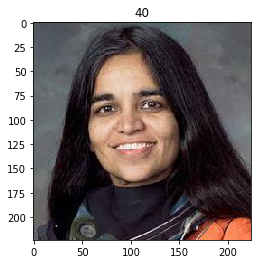

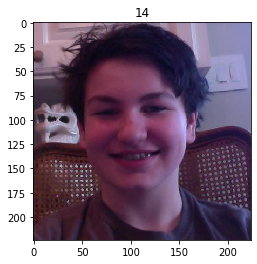

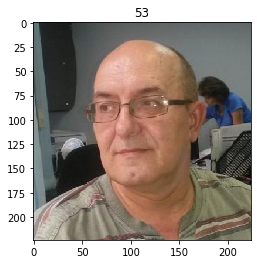

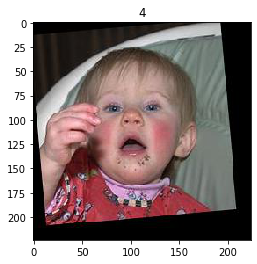

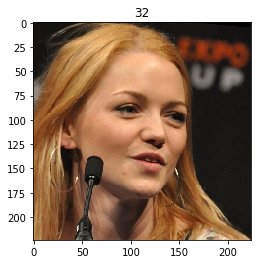

In [8]:
#Выберем 15 фото из обучающей выборке и посмотрим на них
for age, photo in zip(target[:10], features[:10]):
    plt.figure()
    plt.title(age)
    plt.imshow(photo)

In [9]:
photo.shape

(224, 224, 3)

у нас есть повернутые изображения, поэтому мы должны добавить изображения с вращением в процессе обучения размером 224x224, также у нас есть изображения в оттенках серого цвета

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Загрузим данные:
- Примени модель ResNet50 добавив сверху полносвязный слой с Relu активацией. Веса imagenet использовать не будем, так как там задача классификации
- Обучим модель на 10 эпохах и посмотрим кривые обучения

```
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```

2020-12-03 10:34:43.270314: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-12-03 10:34:43.271973: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2020-12-03 10:34:44.670681: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-12-03 10:34:45.291910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-12-03 10:34:45.292002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-12-03 10:34:45.292038: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-12-03 10:34:45.294117: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-12-03 10:34:45.294517: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-12-03 10:34:45.297009: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-12-03 10:34:45.298204: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-12-03 10:34:45.298293: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-12-03 10:34:45.301732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-12-03 10:34:45.302118: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-12-03 10:34:45.309399: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2020-12-03 10:34:45.310057: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x43ab800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-12-03 10:34:45.310083: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-12-03 10:34:45.427835: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4431820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2020-12-03 10:34:45.427880: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2020-12-03 10:34:45.429817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-12-03 10:34:45.429883: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-12-03 10:34:45.429895: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-12-03 10:34:45.429915: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-12-03 10:34:45.429927: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-12-03 10:34:45.429938: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-12-03 10:34:45.429949: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-12-03 10:34:45.429958: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-12-03 10:34:45.433316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-12-03 10:34:45.433396: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-12-03 10:34:45.731104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-12-03 10:34:45.731198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2020-12-03 10:34:45.731226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2020-12-03 10:34:45.734759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2020-12-03 10:34:59.131402: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-12-03 10:34:59.675709: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 98s - loss: 192.9101 - mae: 10.3431 - val_loss: 684.7158 - val_mae: 21.1187
Epoch 2/10
178/178 - 38s - loss: 100.2448 - mae: 7.6946 - val_loss: 514.2004 - val_mae: 17.4495
Epoch 3/10
178/178 - 38s - loss: 63.7855 - mae: 6.0481 - val_loss: 400.6505 - val_mae: 14.8973
Epoch 4/10
178/178 - 38s - loss: 39.0743 - mae: 4.7797 - val_loss: 173.4650 - val_mae: 9.8605
Epoch 5/10
178/178 - 39s - loss: 28.6965 - mae: 4.1766 - val_loss: 95.9869 - val_mae: 7.4199
Epoch 6/10
178/178 - 38s - loss: 20.6042 - mae: 3.5179 - val_loss: 96.5348 - val_mae: 7.6848
Epoch 7/10
178/178 - 38s - loss: 16.2179 - mae: 3.0956 - val_loss: 88.8875 - val_mae: 7.2627
Epoch 8/10
178/178 - 38s - loss: 12.9348 - mae: 2.7563 - val_loss: 81.8695 - val_mae: 6.8984
Epoch 9/10
178/178 - 38s - loss: 12.5088 - mae: 2.6951 - val_loss: 82.9184 - val_mae: 6.9780
Epoch 10/10
178/178 - 38s - loss: 11.1108 - mae: 2.5456 - val_loss: 77.2062 - val_mae: 6.6122
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 77.2062 - mae: 6.6122
Test MAE: 6.6122

```

# 3. Анализ обученной модели

Модель достигла метрики требуемого значения, но, как мы видим, для получения MAE менее 7 мы также можем использовать раннюю остановку и получить результат раньше. Также хорошей практикой является построение кривой обучения и ее проверка.


# Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы